**HR ANALYTICS: PREDICT EMPLOYEE ATTRITION**

**PART 2 - DATA MODELLING**

**Objective**

The objective of this notebook is to build predictive models to predict employee attrition rate for Kaggle's dataset, IBM HR Analytics Employee Attrition and Performance.

**Modelling**

- Features engineering

- Classification model
    - Logistic Regression
    - Random Forest Classifier
    - Gradient Boosting Classifier

- Model evaluation

- Model optimization
    - Random Search
    - Factor Analysis
    - Best Features Selection

- Model comparision between original models and optimized models



In [96]:
import pandas as pd 
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import precision_recall_curve 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, f1_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import prince

In [90]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [30]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn')

In [31]:
data = pd.read_csv('.\data\WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Features engineering

In [32]:
object_features = [x for x in data.columns if data[x].dtype =='object' if x != 'Attrition']
numeric_features = [x for x in data.columns if data[x].dtype!='object']
print('there are %d categogical features'% len(object_features))
print('there are %d numerical features'% len(numeric_features))

there are 8 categogical features
there are 26 numerical features


## Numerical features

**Handle outliers**

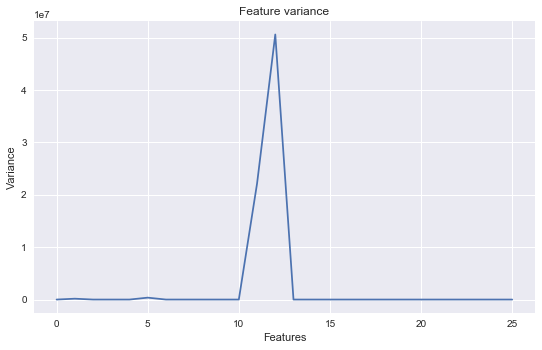

In [33]:
# plot feature variance
plt.figure(figsize=(8,5))
DATA_hist = np.var(data[numeric_features], axis=0)
plt.plot(np.arange(26),DATA_hist)
plt.title("Feature variance")
plt.ylabel('Variance')
plt.xlabel('Features')
plt.show()

Feature MonthlyIncome, MonthlyRate, and NumCompaniesWorked have large variance compared to other features.

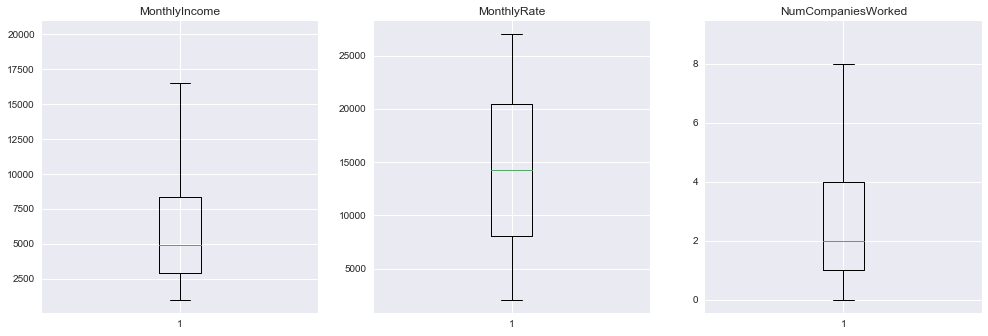

In [34]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.boxplot(data[numeric_features].iloc[:,11])
plt.title('MonthlyIncome')

plt.subplot(1,3,2)
plt.boxplot(data[numeric_features].iloc[:,12])
plt.title('MonthlyRate')

plt.subplot(1,3,3)
plt.boxplot(data[numeric_features].iloc[:,13])
plt.title('NumCompaniesWorked')

plt.show()

Transform MonthlyIncome into categorical feature.

In [35]:
income_mean = data['MonthlyIncome'].mean() 
data['MonthlyIncome']= data['MonthlyIncome'].apply(lambda x: 'high' if x >= income_mean else 'low')

**Group variables**

In [36]:
#Making Age Group 18-24 = Young , 25-54=Middle-Age , 54-120= Old
data['Age']= data['Age'].apply(lambda x: 'Young' if 18 <= x <=24 else 'Middle-Age' if 25 <= x <=54 else 'Old')

In [37]:
TotalSatisfaction = data[['EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','RelationshipSatisfaction','WorkLifeBalance']].apply(lambda x: pd.to_numeric(x))
data['TotalSatisfaction'] = np.sum(TotalSatisfaction,axis = 1)

**Handle correlation**

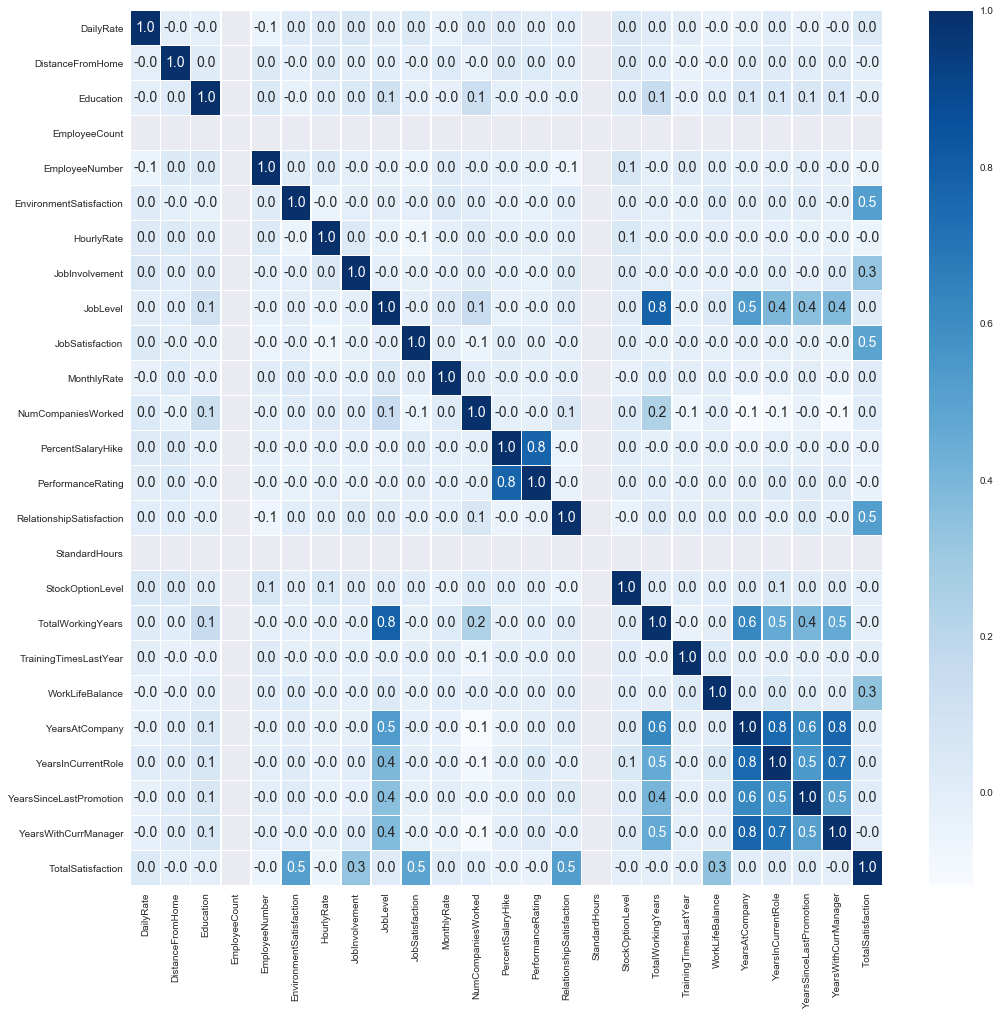

In [38]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),cmap = 'Blues',annot=True, linewidths=.5, fmt= '.1f')

Variables that are highly possitive correlated:
- PercentSalaryHike and PerformanceRating 
- MonthlyIncome and Job Level
- Age and TotalWorkingYears
- TotalWorkingYears and JobLevel
- TotalWorkingYears and MonthlyIncome
- YearsAtCompany, YearsAtCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager, TotalWorkingYears. 

Variables that are moderately positive correlated:
- JobLevel and YearsAtCompany, YearsAtCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager
- MonthlyIncome and YearsAtCompany, YearsAtCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager
- Age and YearsAtCompany, YearsAtCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager

**Handle multicollinearity**

In [40]:
num_features = ['DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeCount',
 'EmployeeNumber',
 'HourlyRate',
 'JobLevel',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [42]:
Xco = data[num_features].assign(const=1)
pd.Series([variance_inflation_factor(Xco.values, i) for i in range(Xco.shape[1])], index=Xco.columns).sort_values()

const                      0.000000
EmployeeCount              0.000000
StandardHours              0.000000
TrainingTimesLastYear      1.008327
HourlyRate                 1.008476
DistanceFromHome           1.009778
MonthlyRate                1.010751
EmployeeNumber             1.012164
DailyRate                  1.015638
StockOptionLevel           1.016679
Education                  1.038821
NumCompaniesWorked         1.233202
YearsSinceLastPromotion    1.668303
PercentSalaryHike          2.508050
PerformanceRating          2.509853
JobLevel                   2.623233
YearsInCurrentRole         2.693360
YearsWithCurrManager       2.736086
TotalWorkingYears          3.486433
YearsAtCompany             4.541763
dtype: float64

**Remove variables with no variance**

The results for all attribute above are (1470,35) => so we can remove these columns and column EmployeeNumber: 35 -4 = 31 variables.


In [43]:
### Remove variables that have no explanatory power
data = data.drop(['Over18', 'EmployeeCount', 'StandardHours', 'EmployeeNumber' ], axis=1)
#axis=1 drops a column (axis=0 drops a row)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 32 columns):
Age                         1470 non-null object
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome               1470 non-null object
MonthlyRate                 1470 non-null int64
NumCompaniesWorked  

## Categorical features

**Create dummy numeric variables for categorical features**

In [44]:
#Update list of categorical features after feature engineering
object_features = [x for x in data.columns if data[x].dtype =='object' if x != 'Attrition']
#Label the atrition 
Attrition = {'Attrition': {"No": 0, "Yes": 1}}
data.replace(Attrition, inplace=True)
#Create dummy variables
processed_data = pd.get_dummies(data, columns= object_features, prefix=object_features)
processed_data.head().style

,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,TotalSatisfaction,Age_Middle-Age,Age_Old,Age_Young,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MonthlyIncome_high,MonthlyIncome_low,OverTime_No,OverTime_Yes
0,1,1102,1,2,2,94,3,2,4,19479,8,11,3,1,0,8,0,1,6,4,0,5,11,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
1,0,279,8,1,3,61,2,2,2,24907,1,23,4,4,1,10,3,3,10,7,1,7,14,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0
2,1,1373,2,2,4,92,2,1,3,2396,6,15,3,2,0,7,3,3,0,0,0,0,14,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
3,0,1392,3,4,4,56,3,1,3,23159,1,11,3,3,0,8,3,3,8,7,3,0,16,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1
4,0,591,2,1,1,40,3,1,2,16632,9,12,3,4,1,6,3,3,2,2,2,2,13,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0


## Split into train and test data 

In [125]:
X, y = processed_data.loc[:, processed_data.columns != 'Attrition'], processed_data['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)

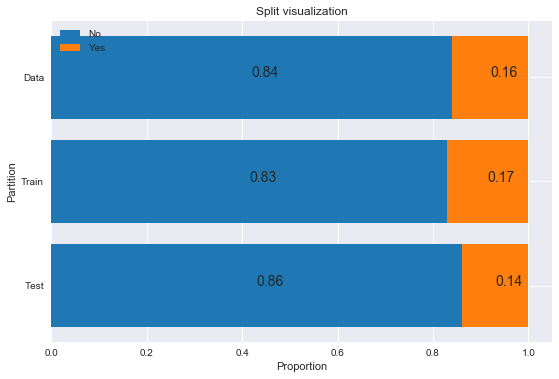

In [126]:
train_dist = y_train.value_counts() / len(y_train)
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['Attrition'].value_counts() / len(data)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='No')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='Yes')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

It is observed that the data is heavily imbalanced. 

## Oversampling with SMOTE

Oversampling is used to synthesize the minority class to cope with the imbalance.

Original label Counter({0: 853, 1: 176})
SMOTE label Counter({0: 853, 1: 853})


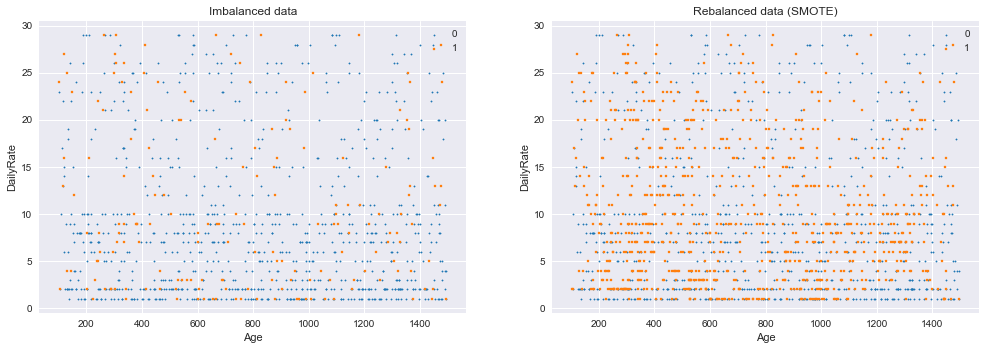

In [127]:

smote = SMOTE(ratio='minority',random_state=1234)
#smote = SMOTEENN(ratio='minority',random_state=1234)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')
    
print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_train_sm))

fig = plt.figure(figsize=(15, 5)) #specify figure size

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='Age', ylabel='DailyRate')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_train_sm), y_train_sm, title='Rebalanced data (SMOTE)', xlabel='Age', ylabel='DailyRate')

# Classification model

In [130]:
def classification_model(model,X_train = X_train_sm,y_train = y_train_sm,X_test=X_test,y_test=y_test,average='macro'):
    
  #Fit the model:
    model.fit(X_train,y_train)
    
  #Perform k-fold cross validation with 5 folds
    kf = KFold(n_splits=5)
    error = []
    for train, test in kf.split(np.array(y_train)):
        
        # Filter training data
        train_predictors = np.array(X_train)[train,:]
    
        # The target we're using to train the algorithm.
        train_target = np.array(y_train)[train]
    
        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)
    
        #Record error from each cross-validation run
        error.append(model.score(np.array(X_train)[test,:], np.array(y_train)[test]))

    #Fit the model again so that it can be refered outside the function:
    model.fit(X_train,y_train) 

    #Make labels predictions on training set and test set
    y_test_predicted = model.predict(X_test.values)
    
    #Make probability predictions on training set and test set for log loss
    y_prob = model.predict_proba(X_test.values)
    
    Accuracy_score = accuracy_score(y_test, y_test_predicted, normalize=True, sample_weight=None)
    F1_score = f1_score(y_test,y_test_predicted, average = average)
    Recall_score = recall_score(y_test,y_test_predicted, average = average)
    Precision_score = precision_score(y_test,y_test_predicted, average = average)
    Log_loss_score = log_loss(y_test,np.array(y_prob),labels = [0,1],eps=1e-15)
    Confusion_matrix = confusion_matrix(y_test, y_test_predicted)
    
    if hasattr(model, 'feature_importances_'):
        Features_importance = model.feature_importances_.flatten()
    elif hasattr(model, 'coef_'):
        Features_importance = model.coef_.flatten()
    
    return y_test_predicted,y_prob[:,1], Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance 
    

**Applied algorithms:**
- Logistic Regression
- Random Forest Classifier
- Gradient Boosting Classifier

In [131]:
lr_y_test_predicted, lr_y_prob,lr_Accuracy_score, lr_F1_score, lr_Recall_score, lr_Precision_score,lr_Log_loss_score, lr_Confusion_matrix,lr_Features_importance = classification_model(LogisticRegression(solver='liblinear',penalty='l1',random_state=1234))
dt_y_test_predicted, dt_y_prob, dt_Accuracy_score, dt_F1_score, dt_Recall_score, dt_Precision_score,dt_Log_loss_score, dt_Confusion_matrix, dt_Features_importance = classification_model(RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=9,min_samples_split=5,max_features=3,random_state=1234))
xgb_y_test_predicted, xgb_y_prob, xgb_Accuracy_score, xgb_F1_score, xgb_Recall_score, xgb_Precision_score, xgb_Log_loss_score, xgb_Confusion_matrix, xgb_Features_importance = classification_model(GradientBoostingClassifier(learning_rate=0.1, loss='deviance', max_depth=5,random_state=1234))

# Model evaluation 

## Model evaluation on both classes

**Accuracy score, F1 score, Recall score, Precision score, Log loss score**

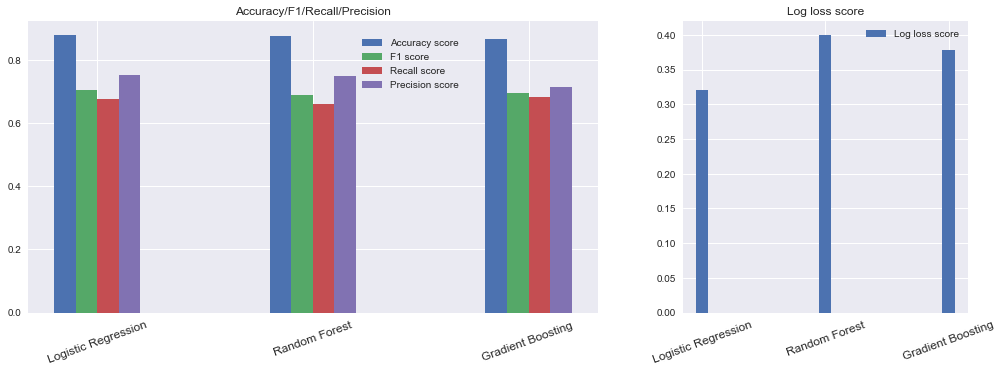

In [78]:
model_comparison = pd.DataFrame({
    'model': ['Logistic Regression','Random Forest','Gradient Boosting'],
    'Accuracy score': [lr_Accuracy_score,dt_Accuracy_score,xgb_Accuracy_score],
    'F1_score': [lr_F1_score,dt_F1_score,xgb_F1_score],
    'Recall score': [lr_Recall_score,dt_Recall_score,xgb_Recall_score],
    'Precision score': [lr_Precision_score, dt_Precision_score, xgb_Precision_score],
    'Log loss score': [lr_Log_loss_score, dt_Log_loss_score,xgb_Log_loss_score]
})

plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])

ax0 = plt.subplot(gs[0])
index = np.arange(3)
#index, label = plt.xticks(np.arange(3),('Logistic Regression','Decision Tree','XGBClassifier'))
a = plt.bar(index+0.00,model_comparison['Accuracy score'].values,width= 0.1, label = 'Accuracy score')
b = plt.bar(index + 0.1,model_comparison['F1_score'].values,width = 0.1, label = 'F1 score')
c =plt.bar(index + 0.2,model_comparison['Recall score'].values,width = 0.1, label = 'Recall score')
d =plt.bar(index + 0.3,model_comparison['Precision score'].values,width = 0.1, label = 'Precision score')
ax0.set_xticks(index + 0.15)
ax0.set_xticklabels( ('Logistic Regression','Random Forest','Gradient Boosting '),size =12)
plt.legend(loc = (0.58,0.75))
plt.xticks(rotation=20)
plt.title('Accuracy/F1/Recall/Precision')

ax1 = plt.subplot(gs[1])
ax1 = plt.bar(model_comparison['model'],model_comparison['Log loss score'].values,width = 0.1, label = 'Log loss score')
plt.xticks(rotation=20,size=12)
plt.title('Log loss score')
plt.legend()

plt.show()

**Precision/Recall curve, ROC curve**

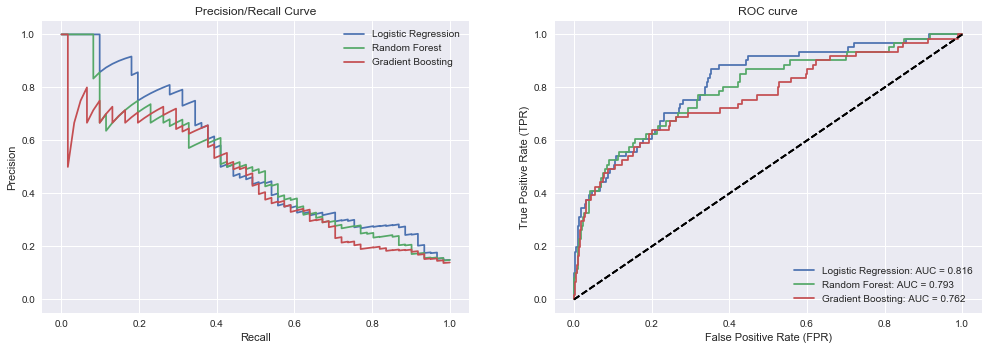

In [79]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision/Recall Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for test, pred, num, name in zip([y_test, y_test, y_test], [lr_y_prob, dt_y_prob,xgb_y_prob], range(1,4), ['Logistic Regression','Random Forest','Gradient Boosting']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    precision, recall, _ = precision_recall_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    ax2.plot([0,1],[0,1],color='black', linestyle='--')
    ax1.plot(recall,precision,label = name)
    ax1.legend()

plt.title('ROC curve')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

## Model evaluation on each attrition class

In [85]:
lr_y_test_predicted_c, lr_y_prob_c,lr_Accuracy_score_c, lr_F1_score_c, lr_Recall_score_c, lr_Precision_score_c,lr_Log_loss_score_c, lr_Confusion_matrix_c,lr_Features_importance_c = classification_model(LogisticRegression(solver='liblinear',penalty='l1',random_state=1234),average=None)
dt_y_test_predicted_c, dt_y_prob_c, dt_Accuracy_score_c, dt_F1_score_c, dt_Recall_score_c, dt_Precision_score_c,dt_Log_loss_score_c, dt_Confusion_matrix_c, dt_Features_importance_c = classification_model(RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=9,min_samples_split=5,max_features=3,random_state=1234),average=None)
xgb_y_test_predicted_c, xgb_y_prob_c, xgb_Accuracy_score_c, xgb_F1_score_c, xgb_Recall_score_c, xgb_Precision_score_c, xgb_Log_loss_score_c, xgb_Confusion_matrix_c, xgb_Features_importance_c = classification_model(GradientBoostingClassifier(learning_rate=0.1, loss='deviance', max_depth=5,random_state=1234),average=None)

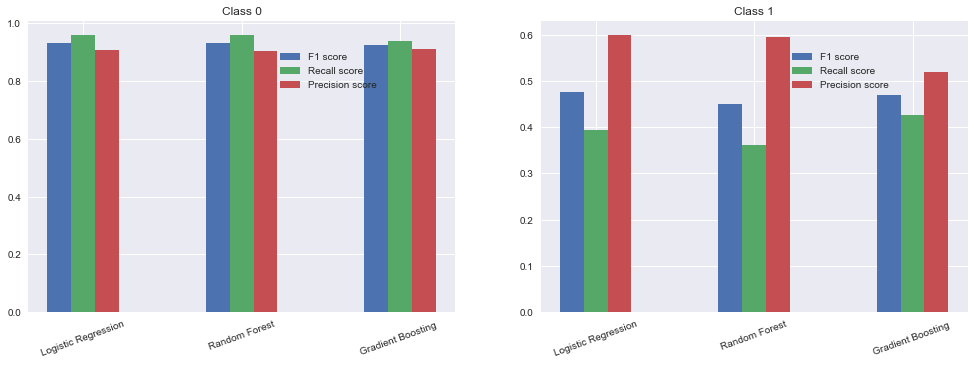

In [88]:
model_comparison_1 = pd.DataFrame({
    'model': ['Logistic Regression','Random Forest','Gradient Boosting'],
    'F1_score': [lr_F1_score_c[0],dt_F1_score_c[0],xgb_F1_score_c[0]],
    'Recall score': [lr_Recall_score_c[0],dt_Recall_score_c[0],xgb_Recall_score_c[0]],
    'Precision score': [lr_Precision_score_c[0], dt_Precision_score_c[0], xgb_Precision_score_c[0]]
})

model_comparison_2 = pd.DataFrame({
    'model': ['Logistic Regression','Random Forest','Gradient Boosting'],
    'F1_score': [lr_F1_score_c[1],dt_F1_score_c[1],xgb_F1_score_c[1]],
    'Recall score': [lr_Recall_score_c[1],dt_Recall_score_c[1],xgb_Recall_score_c[1]],
    'Precision score': [lr_Precision_score_c[1], dt_Precision_score_c[1], xgb_Precision_score_c[1]]
})

plt.figure(figsize=(15,5))
plt.subplot(121)

index = np.arange(3)
#index, label = plt.xticks(np.arange(3),('Logistic Regression','Decision Tree','XGBClassifier'))
b = plt.bar(index + 0.0,model_comparison_1['F1_score'].values,width = 0.15, label = 'F1 score')
c =plt.bar(index + 0.15,model_comparison_1['Recall score'].values,width = 0.15, label = 'Recall score')
d =plt.bar(index + 0.3,model_comparison_1['Precision score'].values,width = 0.15, label = 'Precision score')
plt.xticks(index + 0.15,  ('Logistic Regression','Random Forest','Gradient Boosting '))
#plt.xticklabels( ('Logistic Regression','Random Forest','Gradient Boosting '),size =12)
plt.legend(loc = (0.58,0.75))
plt.xticks(rotation=20)
plt.title('Class 0')

plt.subplot(122)
index = np.arange(3)
#index, label = plt.xticks(np.arange(3),('Logistic Regression','Decision Tree','XGBClassifier'))
b = plt.bar(index + 0.0,model_comparison_2['F1_score'].values,width = 0.15, label = 'F1 score')
c =plt.bar(index + 0.15,model_comparison_2['Recall score'].values,width = 0.15, label = 'Recall score')
d =plt.bar(index + 0.3,model_comparison_2['Precision score'].values,width = 0.15, label = 'Precision score')
plt.xticks(index + 0.15,  ('Logistic Regression','Random Forest','Gradient Boosting '))
#plt.xticklabels( ('Logistic Regression','Random Forest','Gradient Boosting '),size =12)
plt.legend(loc = (0.58,0.75))
plt.xticks(rotation=20)
plt.title('Class 1')

plt.show()

87% accuracy, 70% f1, recall, precision scores, 0.4 Log Loss, 80% AUC score.

More difficult to predict minority/target class.

High tradeoff between Precision and Recall.


# Model Optimization

**Goal**

Improve recall score to classify as many quitting employees as possible, while the cost of classifying quitting employees as non-quitting is higher than thecost of classifying non-quitting employees as quitting is assumed. 

**Methods**
- **Random Search**: Search for the best parameters of three models toimprove the recall score.
- **Factor Analysis**: Implement the best parameters found by Random Search into three models. Feed each model with different numbers of component analysis to observe how therecall and precision scores fluctuate.
- **Best Features Selection**: Implement best parameters from Random Search into three models. Feed each model with different numbers of best featuresproduced by each model to observe how the recall and precision scores fluctuate

## Random search

In [91]:
def random_search_wrapper(estimator,hyperparameter_grid, refit_score='recall_score'):
    
    #Define scores to optimize
    scorers = {
    #'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score)}
    
    # Set up the random search with 4-fold cross validation
    random_cv = RandomizedSearchCV(estimator,
                                   param_distributions=hyperparameter_grid,
                                   cv=4, n_iter=25, 
                                   scoring = scorers,
                                   n_jobs = -1, verbose = 1, 
                                   return_train_score = True,
                                   random_state=1234,refit=refit_score )
    
    # Fit on the training balanced data
    random_cv.fit(X_train_sm, y_train_sm)

    # make the predictions
    y_pred = random_cv.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(random_cv.best_estimator_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of {} optimized for {} on the test data:'.format(estimator, refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return random_cv

**Random search for Logistic Regression**

In [92]:
#Logistic Regression
penalty = ['l1','l2']
    
C= [0.01, 0.1, 1, 2]

#solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Define the grid of hyperparameters to search
hyperparameter_grid = {'penalty' : penalty,
                       'C': C}
random_search_wrapper(LogisticRegression(),hyperparameter_grid, refit_score='recall_score')

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best params for recall_score
LogisticRegression(C=0.01)

Confusion matrix of LogisticRegression() optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       276       104
pos        25        36


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    6.2s finished


RandomizedSearchCV(cv=4, estimator=LogisticRegression(), n_iter=25, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 2],
                                        'penalty': ['l1', 'l2']},
                   random_state=1234, refit='recall_score',
                   return_train_score=True,
                   scoring={'recall_score': make_scorer(recall_score)},
                   verbose=1)

**Random search for Random Forest**

In [93]:
#Random Forest
criterion = ['gini','entropy']

# Number of trees used in the boosting process
n_estimators = [10,50, 100]

# Maximum depth of each tree
max_depth = [3, 6, 9]

# Minimum number of samples per leaf
min_samples_leaf = [3,6,9]

# Minimum number of samples to split a node
min_samples_split = [3,6,9]

# Maximum number of features to consider for making splits
max_features = ['sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'criterion' : criterion,
                           'n_estimators': n_estimators,
                           'max_depth': max_depth,
                           'min_samples_leaf': min_samples_leaf,
                           'min_samples_split': min_samples_split,
                           'max_features': max_features}

random_search_wrapper(RandomForestClassifier(),hyperparameter_grid, refit_score='recall_score')

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s


Best params for recall_score
RandomForestClassifier(max_depth=6, max_features='log2', min_samples_leaf=6,
                       min_samples_split=9, n_estimators=10)

Confusion matrix of RandomForestClassifier() optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       347        33
pos        38        23


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [3, 6, 9],
                                        'min_samples_split': [3, 6, 9],
                                        'n_estimators': [10, 50, 100]},
                   random_state=1234, refit='recall_score',
                   return_train_score=True,
                   scoring={'recall_score': make_scorer(recall_score)},
                   verbose=1)

**Random search for Gradient Boosting**

In [94]:
#Gradient Boosting
#learning_rate
learning_rate = [0.01,0.05,0.1]
    
# Number of trees used in the boosting process
n_estimators = [70, 100, 500]

# Maximum depth of each tree
max_depth = [3, 5, 10]

# Minimum number of samples per leaf
min_samples_leaf = [2, 4, 6]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6]

# Maximum number of features to consider for making splits
max_features = ['sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'learning_rate': learning_rate,
                           'n_estimators': n_estimators,
                           'max_depth': max_depth,
                           'min_samples_leaf': min_samples_leaf,
                           'min_samples_split': min_samples_split,
                           'max_features': max_features}
random_search_wrapper(GradientBoostingClassifier(),hyperparameter_grid, refit_score='recall_score')

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.6s finished


Best params for recall_score
GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                           max_features='sqrt', min_samples_leaf=6,
                           min_samples_split=6)

Confusion matrix of GradientBoostingClassifier() optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       362        18
pos        38        23


RandomizedSearchCV(cv=4, estimator=GradientBoostingClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 10],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [70, 100, 500]},
                   random_state=1234, refit='recall_score',
                   return_train_score=True,
                   scoring={'recall_score': make_scorer(recall_score)},
                   verbose=1)

## Supervised Factor Analysis

**Supervised Factor Analysis - Logistic Regression**

Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


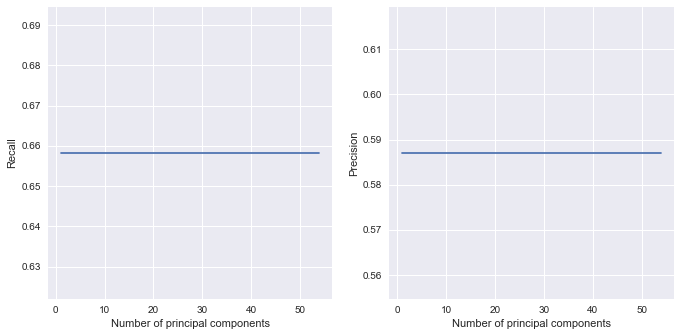

In [99]:
#Logistic Regression
PC = np.array([1,5,10,20,30,40,45,50,54])
recall = []
precision = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    j = PC[i]
    famd = prince.FAMD(n_components=j)
    famd = famd.fit(data.drop('Attrition', axis='columns'))
    output = famd.row_coordinates(data.drop('Attrition', axis='columns'))
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(output, y, test_size = 0.3, random_state = 12345)
    
    #oversample
    smote = SMOTE(ratio='minority',random_state=1234)
    X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
    # train and predict
    y_test_predicted, y_prob,Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance = classification_model(
        LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100,
          n_jobs=None, penalty='l2', random_state=None,
          tol=0.0001, verbose=0, warm_start=False)
    )


    recall.append(Recall_score)
    precision.append(Precision_score)
    
plt.figure(figsize=(10,5))
plt.title("Logistic Regression performance with different number of principal components")
plt.subplot(1,2,1)
plt.plot(PC,recall)
plt.ylabel('Recall')
plt.xlabel('Number of principal components')


plt.subplot(1,2,2)
plt.plot(PC,precision)
plt.ylabel('Precision')
plt.xlabel('Number of principal components')
plt.show()

**Supervised Factor Analysis - Random Forest**

Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


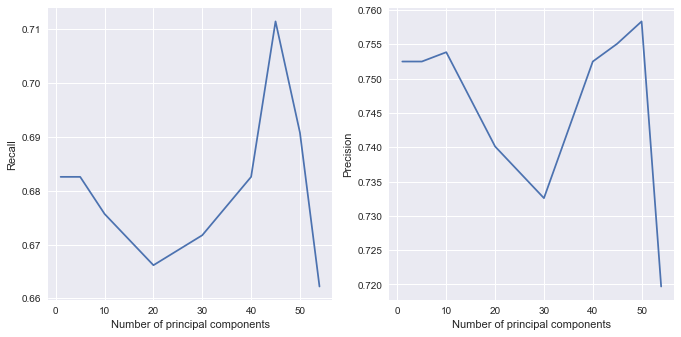

In [100]:
#Random Forest
PC = np.array([1,5,10,20,30,40,45,50,54])
recall = []
precision = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    j = PC[i]
    famd = prince.FAMD(n_components=j)
    famd = famd.fit(data.drop('Attrition', axis='columns'))
    output = famd.row_coordinates(data.drop('Attrition', axis='columns'))
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(output, y, test_size = 0.3, random_state = 12345)
    
    #oversample
    smote = SMOTE(ratio='minority',random_state=1234)
    X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
    # train and predict
    y_test_predicted, y_prob,Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance = classification_model(
        RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))


    recall.append(Recall_score)
    precision.append(Precision_score)
    
plt.figure(figsize=(10,5))
plt.title("Logistic Regression performance with different number of principal components")
plt.subplot(1,2,1)
plt.plot(PC,recall)
plt.ylabel('Recall')
plt.xlabel('Number of principal components')


plt.subplot(1,2,2)
plt.plot(PC,precision)
plt.ylabel('Precision')
plt.xlabel('Number of principal components')
plt.show()

**Supervised Factor Analysis - Gradient Boosting**

Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


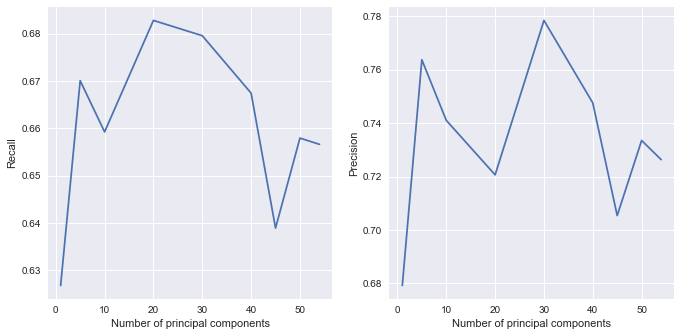

In [103]:
#Gradient Boosting
PC = np.array([1,5,10,20,30,40,45,50,54])
recall = []
precision = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    j = PC[i]
    famd = prince.FAMD(n_components=j)
    famd = famd.fit(data.drop('Attrition', axis='columns'))
    output = famd.row_coordinates(data.drop('Attrition', axis='columns'))
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(output, y, test_size = 0.3, random_state = 12345)
    
    #oversample
    smote = SMOTE(ratio='minority',random_state=1234)
    X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
    # train and predict
    y_test_predicted, y_prob,Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance = classification_model(
        GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
    )


    recall.append(Recall_score)
    precision.append(Precision_score)
    
plt.figure(figsize=(10,5))
plt.title("Logistic Regression performance with different number of principal components")
plt.subplot(1,2,1)
plt.plot(PC,recall)
plt.ylabel('Recall')
plt.xlabel('Number of principal components')


plt.subplot(1,2,2)
plt.plot(PC,precision)
plt.ylabel('Precision')
plt.xlabel('Number of principal components')
plt.show()

**Best Features Selection**

In [132]:
features_importance = pd.DataFrame({'feature':list(X_train.columns),
                                    'lr':lr_Features_importance,
                                    'rf':dt_Features_importance,
                                    'gb': xgb_Features_importance
                                   })


Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


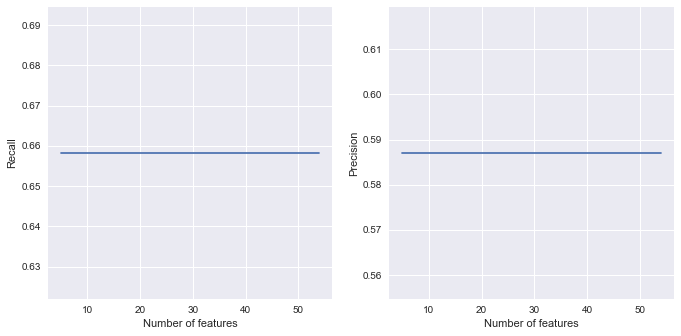

In [134]:
#Logistic Regression
PC = np.array([5,10,15,20,30,40,45,50,54])
recall = []
precision = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    j = PC[i]
    features = features_importance.sort_values(by = 'lr')['feature'][:j]
    output = X[features]
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
    
    #oversample
    smote = SMOTE(ratio='minority',random_state=1234)
    X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
    # train and predict
    y_test_predicted, y_prob,Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance = classification_model(
        LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100,
          n_jobs=None, penalty='l2', random_state=None,
          tol=0.0001, verbose=0, warm_start=False)
    )

    recall.append(Recall_score)
    precision.append(Precision_score)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(PC,recall)

plt.ylabel('Recall')
plt.xlabel('Number of features')


plt.subplot(1,2,2)
plt.plot(PC,precision)
#plt.title("Logistic Regression performance with different number of principal components")
plt.ylabel('Precision')
plt.xlabel('Number of features')
plt.show()

Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


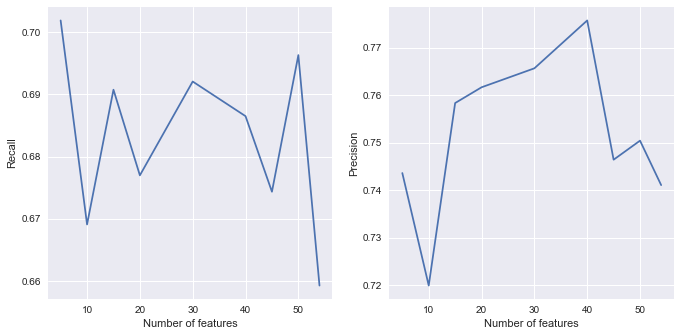

In [135]:
#Random Forest
PC = np.array([5,10,15,20,30,40,45,50,54])
recall = []
precision = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    j = PC[i]
    features = features_importance.sort_values(by = 'rf')['feature'][:j]
    output = X[features]
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
    
    #oversample
    smote = SMOTE(ratio='minority',random_state=1234)
    X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
    # train and predict
    y_test_predicted, y_prob,Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance = classification_model(
        RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))

    recall.append(Recall_score)
    precision.append(Precision_score)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(PC,recall)

plt.ylabel('Recall')
plt.xlabel('Number of features')


plt.subplot(1,2,2)
plt.plot(PC,precision)
#plt.title("Logistic Regression performance with different number of principal components")
plt.ylabel('Precision')
plt.xlabel('Number of features')
plt.show()

Progress:
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


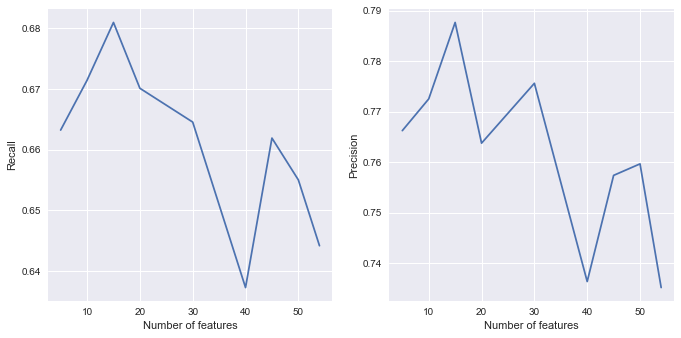

In [136]:
#Gradient Boosting
PC = np.array([5,10,15,20,30,40,45,50,54])
recall = []
precision = []

print('Progress:')
for i in range(PC.shape[0]):
    print(i+1,'/',9)
    j = PC[i]
    features = features_importance.sort_values(by = 'gb')['feature'][:j]
    output = X[features]
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
    
    #oversample
    smote = SMOTE(ratio='minority',random_state=1234)
    X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
    # train and predict
    y_test_predicted, y_prob,Accuracy_score, F1_score, Recall_score, Precision_score,Log_loss_score, Confusion_matrix,Features_importance = classification_model(
        GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=10,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
    )

    recall.append(Recall_score)
    precision.append(Precision_score)
    
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(PC,recall)

plt.ylabel('Recall')
plt.xlabel('Number of features')


plt.subplot(1,2,2)
plt.plot(PC,precision)
#plt.title("Logistic Regression performance with different number of principal components")
plt.ylabel('Precision')
plt.xlabel('Number of features')
plt.show()

Recall and precision scores remain constant in Logistic Regression while fluctuate drastically in Random Forest and Gradient Boosting classifiers.

The overall obtained maximum recall score is approximately 71%. Thus, there is some small improvement from the original models.


## Final result

In [138]:
#logistic regression
features = features_importance.sort_values(by = 'lr')['feature']
output = X[features]
    
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
    
#oversample
smote = SMOTE(ratio='minority',random_state=1234)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
# train and predict
lr_y_test_predicted_n, lr_y_prob_n,lr_Accuracy_score_n, lr_F1_score_n, lr_Recall_score_n, lr_Precision_score_n,lr_Log_loss_score_n, lr_Confusion_matrix_n,lr_Features_importance_n = classification_model(
    LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100,
          n_jobs=None, penalty='l2', random_state=1,
          tol=0.0001, verbose=0, warm_start=False
    )
    )

In [139]:
#randomforest
features = features_importance.sort_values(by = 'rf')['feature'][:50]
output = X[features]
    
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
    
#oversample
smote = SMOTE(ratio='minority',random_state=1234)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
# train and predict
dt_y_test_predicted_n, dt_y_prob_n,dt_Accuracy_score_n, dt_F1_score_n, dt_Recall_score_n, dt_Precision_score_n,dt_Log_loss_score_n, dt_Confusion_matrix_n,dt_Features_importance_n = classification_model(
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1, verbose=0,
            warm_start=False)
    )

In [140]:
#gradientboosting
features = features_importance.sort_values(by = 'gb')['feature'][:45]
output = X[features]
    
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)
    
#oversample
smote = SMOTE(ratio='minority',random_state=1234)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
    
# train and predict
xgb_y_test_predicted_n, xgb_y_prob_n,xgb_Accuracy_score_n, xgb_F1_score_n, xgb_Recall_score_n, xgb_Precision_score_n,xgb_Log_loss_score_n, xgb_Confusion_matrix_n,xgb_Features_importance_n = classification_model(
    GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=4, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
    )

## Compare between old models and optimized models

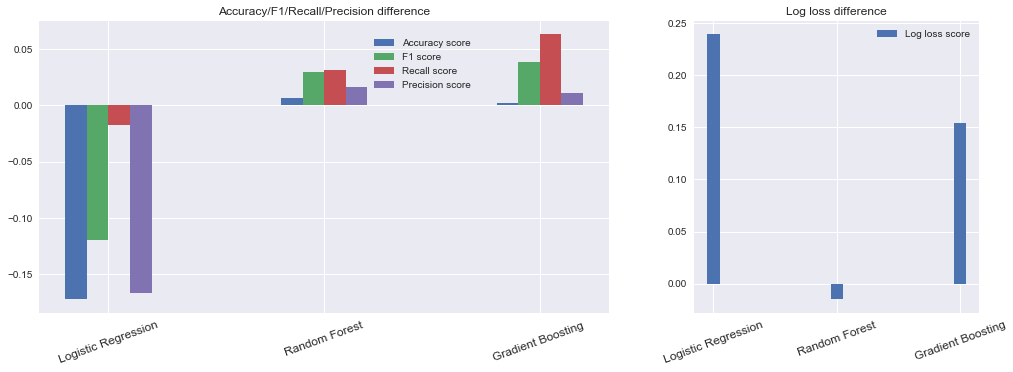

In [142]:
#Result table from optimized models
model_comparison_new = pd.DataFrame({
    'model': ['Logistic Regression','Random Forest','Gradient Boosting'],
    'Accuracy score': [lr_Accuracy_score_n,dt_Accuracy_score_n,xgb_Accuracy_score_n],
    'F1_score': [lr_F1_score_n,dt_F1_score_n,xgb_F1_score_n],
    'Recall score': [lr_Recall_score_n,dt_Recall_score_n,xgb_Recall_score_n],
    'Precision score': [lr_Precision_score_n, dt_Precision_score_n, xgb_Precision_score_n],
    'Log loss score': [lr_Log_loss_score_n, dt_Log_loss_score_n,xgb_Log_loss_score_n]
})

#Result table from old models
model_comparison_old = pd.DataFrame({
    'model': ['Logistic Regression','Random Forest','Gradient Boosting'],
    'Accuracy score': [lr_Accuracy_score,dt_Accuracy_score,xgb_Accuracy_score],
    'F1_score': [lr_F1_score,dt_F1_score,xgb_F1_score],
    'Recall score': [lr_Recall_score,dt_Recall_score,xgb_Recall_score],
    'Precision score': [lr_Precision_score, dt_Precision_score, xgb_Precision_score],
    'Log loss score': [lr_Log_loss_score, dt_Log_loss_score,xgb_Log_loss_score]
})

#Difference in the scores between old and optimized models
result_score = model_comparison_new.iloc[:,1:].values - model_comparison_old.iloc[:,1:].values

#Plot the difference in the scores
score_comparison = pd.DataFrame({
    'model': ['Logistic Regression','Random Forest','Gradient Boosting'],
    'Accuracy score': result_score[:,0] ,
    'F1_score': result_score[:,1],
    'Recall score': result_score[:,2],
    'Precision score':result_score[:,3],
    'Log loss score': result_score[:,4]
})

plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])

ax0 = plt.subplot(gs[0])
index = np.arange(3)
#index, label = plt.xticks(np.arange(3),('Logistic Regression','Decision Tree','XGBClassifier'))
a = plt.bar(index+0.00,score_comparison['Accuracy score'].values,width= 0.1, label = 'Accuracy score')
b = plt.bar(index + 0.1,score_comparison['F1_score'].values,width = 0.1, label = 'F1 score')
c =plt.bar(index + 0.2,score_comparison['Recall score'].values,width = 0.1, label = 'Recall score')
d =plt.bar(index + 0.3,score_comparison['Precision score'].values,width = 0.1, label = 'Precision score')
ax0.set_xticks(index + 0.15)
ax0.set_xticklabels( ('Logistic Regression','Random Forest','Gradient Boosting '),size =12)
plt.legend(loc = (0.58,0.75))
plt.xticks(rotation=20)
plt.title('Accuracy/F1/Recall/Precision difference')
ax0.set_axis_on()

ax1 = plt.subplot(gs[1])
ax1 = plt.bar(model_comparison['model'],score_comparison['Log loss score'].values,width = 0.1, label = 'Log loss score')
plt.xticks(rotation=20,size=12)
plt.title('Log loss difference')
plt.legend()

plt.show()

All three optimized models have improvement in recall score. 
The recall is improved while precision is decreased.
Gradient Boosting has the highest Accuracy/F1A/Recall/Precision scores but Log Loss score is worse then the original model.


**Optimized Gradient Boosting performance**

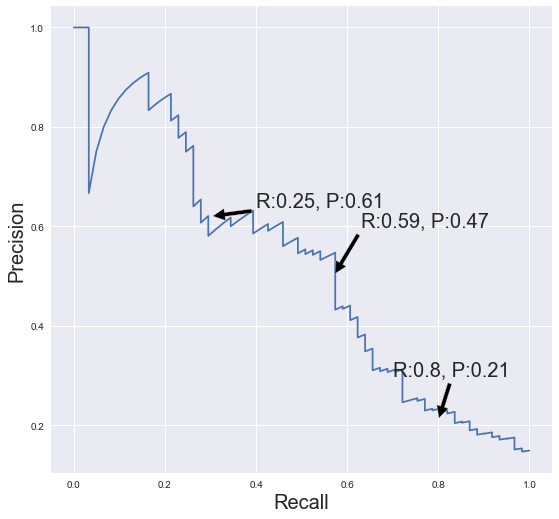

In [162]:
precision, recall, _ = precision_recall_curve(y_test, xgb_y_prob_n)
plt.figure(figsize=(8,8))
plt.plot(recall,precision)
plt.xlabel('Recall',size=20)
plt.ylabel('Precision',size=20)
plt.grid(True)
plt.annotate('R:0.8, P:0.21', xy= (0.8,0.21), xytext=(0.7, 0.3),arrowprops=dict(facecolor='black', shrink=0.05),size=20)
plt.annotate('R:0.25, P:0.61', xy= (0.3, 0.62), xytext=(0.4, 0.64),arrowprops=dict(facecolor='black', shrink=0.05),size=20)
plt.annotate('R:0.59, P:0.47', xy= (0.57,0.5), xytext=(0.63, 0.6),arrowprops=dict(facecolor='black', shrink=0.05),size=20)
plt.show()

Optimize further the recall score by choosing different thresholds with the precision score as the opportunity cost.


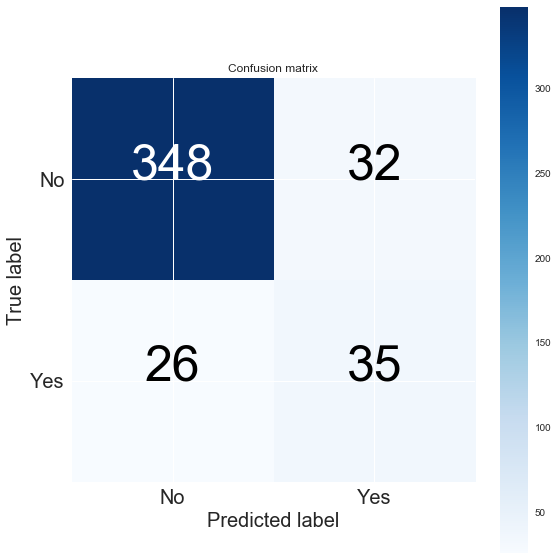

In [145]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,size=20)
    plt.yticks(tick_marks, classes,size=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",size=50)

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)
    
class_names = ['No', 'Yes']
plt.figure(figsize=(8,8))
plot_confusion_matrix(xgb_Confusion_matrix_n, classes=class_names,
                      title='Confusion matrix')

# Features Importance

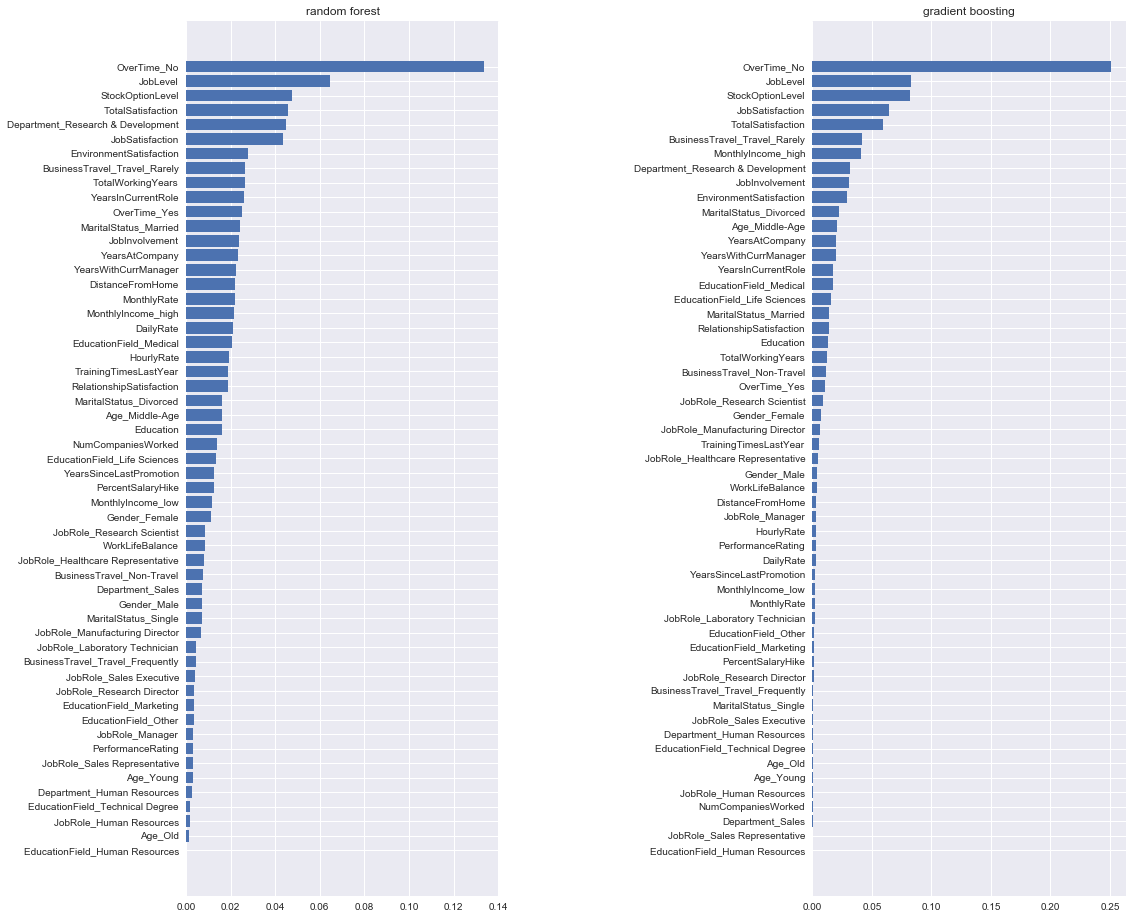

In [157]:
features_importance = pd.DataFrame({'feature':list(X_train.columns),
                                    'lr':lr_Features_importance_n,
                                    'rf':dt_Features_importance_n,
                                    'gb': xgb_Features_importance_n
                                   })
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
rf = features_importance.sort_values(by = 'rf')
plt.barh(rf['feature'],rf['rf'])
plt.title('random forest')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)


plt.subplot(1,2,2)
gb = features_importance.sort_values(by = 'gb')
plt.barh(gb['feature'],gb['gb'])
plt.title('gradient boosting')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)

plt.show()

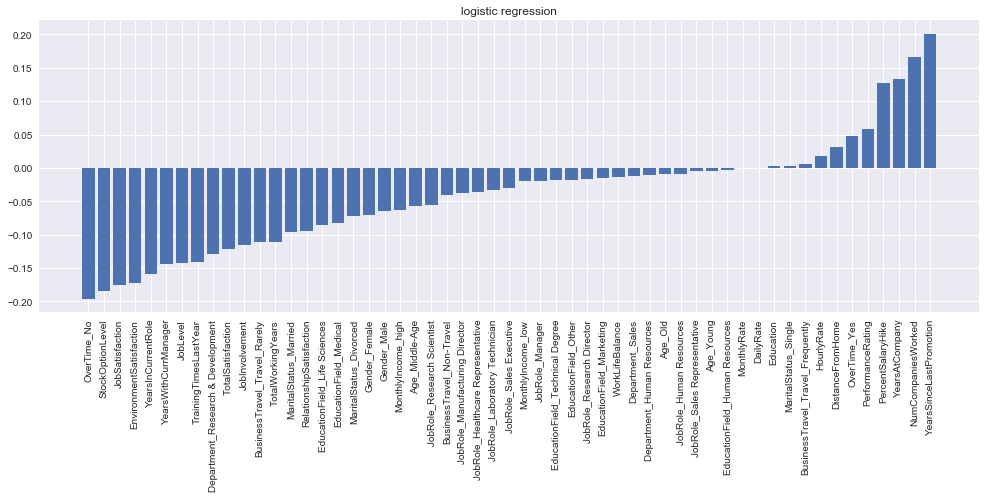

In [160]:
plt.figure(figsize=(15,5))

lr = features_importance.sort_values(by = 'lr')
plt.bar(lr['feature'],lr['lr'])
plt.title('logistic regression')
plt.xticks(list(X_train.columns),rotation=90)

plt.show()